In [1]:
import keras
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
from torch.autograd import Variable
from torchsummary import summary
import torch.optim as optim
import time
import matplotlib
from torch.utils.data import DataLoader
import torch.utils.data as data
import numpy as np
import pandas as pd
import Deep_learning_torch_func as DL
#import simdat_read_func as simr
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
fashion_mnist = fetch_openml('Fashion-MNIST')
mnist = fetch_openml('mnist_784')
xf,yf=fashion_mnist['data'],fashion_mnist['target']
xm,ym=mnist['data'],mnist['target']

In [8]:
print(type(xf),type(yf),type(xm),type(ym))
print(xf.shape,yf.shape,xm.shape,ym.shape)
print(type(xf[0][0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(70000, 784) (70000,) (70000, 784) (70000,)
<class 'numpy.float64'>


In [3]:
xf=xf.reshape(70000,1,28,28)
xm=xm.reshape(70000,1,28,28)

In [4]:
yf=yf.astype(int)
ym=ym.astype(int)

In [5]:
xf = torch.tensor(xf,dtype=torch.float32)
yf = torch.tensor(yf, dtype=torch.int64)
xm = torch.tensor(xm,dtype=torch.float32)
ym = torch.tensor(ym, dtype=torch.int64)

In [6]:
xf_t,xf_v=xf[:60000],xf[60000:]
xm_t,xm_v=xm[:60000],xm[60000:]
yf_t,yf_v=yf[:60000],yf[60000:]
ym_t,ym_v=ym[:60000],ym[60000:]

In [13]:
print(xf_t.shape)

torch.Size([60000, 1, 28, 28])


In [14]:
m_t = torch.utils.data.TensorDataset(xm_t, ym_t)
m_v = torch.utils.data.TensorDataset(xm_v, ym_v)
fm_t = torch.utils.data.TensorDataset(xf_t, yf_t)
fm_v = torch.utils.data.TensorDataset(xf_v, yf_v)

In [ ]:
batch=64
m_l_t=DataLoader(m_t,batch_size=batch,shuffle=True)
m_l_v=DataLoader(m_v,batch_size=batch,shuffle=True)
fm_l_t=DataLoader(fm_t,batch_size=batch,shuffle=True)
fm_l_v=DataLoader(fm_v,batch_size=batch,shuffle=True)

In [15]:
batch=128
m_l_t=DataLoader(m_t,batch_size=batch,shuffle=True)
m_l_v=DataLoader(m_v,batch_size=batch,shuffle=True)
fm_l_t=DataLoader(fm_t,batch_size=batch,shuffle=True)
fm_l_v=DataLoader(fm_v,batch_size=batch,shuffle=True)

In [16]:
label_classes=10
class mnist_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.CNN2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # self.CNN3 = nn.Sequential(
        #     nn.Conv2d(64, 32, kernel_size=3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        # self.CNN4 = nn.Sequential(
        #     nn.Conv2d(32, 16, kernel_size=3),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2))
        self.dropout = nn.Dropout(0.1)
        self.l1 = nn.Linear(58 * 58 * 64, 1024)
        self.l2 = nn.Linear(2048, 1024)
        self.l3 = nn.Linear(1024, 512)
        self.l4 = nn.Linear(512, 128)
        self.l5 = nn.Linear(16*4*4, 128)
        self.l6 = nn.Linear(128,64)
        self.l7 = nn.Linear(64,32)
        self.fc = nn.Linear(32, label_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.CNN1(x)
        x = self.CNN2(x)
        # x = self.CNN3(x)
        # x = self.CNN4(x)
        x = x.view(x.size(0), -1)
        x = self.l5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l6(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l7(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

modellist=[]
optimizerlist=[]
criterion = nn.CrossEntropyLoss()
for i in range(2):
  modeltmp=mnist_net()
  modeltmp=modeltmp.to(device)
  summary(modeltmp,input_size=(1,28,28))
  optimizertmp = optim.SGD(modeltmp.parameters(), lr=0.01)
  modellist.append(modeltmp)
  optimizerlist.append(optimizertmp)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             544
       BatchNorm2d-2           [-1, 32, 25, 25]              64
              ReLU-3           [-1, 32, 25, 25]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5             [-1, 16, 9, 9]           8,208
       BatchNorm2d-6             [-1, 16, 9, 9]              32
              ReLU-7             [-1, 16, 9, 9]               0
         MaxPool2d-8             [-1, 16, 4, 4]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
          Dropout-14                   

batch128 lr0.01

エポック1 ,val_acc0.678 ,train_acc0.6830833333333334
epochtime:0.12204039096832275分
エポック2 ,val_acc0.942 ,train_acc0.9378333333333333
epochtime:0.1203458070755005分
エポック3 ,val_acc0.9674 ,train_acc0.9628833333333333
epochtime:0.12095754941304525分
エポック4 ,val_acc0.9738 ,train_acc0.9719166666666667
epochtime:0.11888210773468018分
エポック5 ,val_acc0.9753 ,train_acc0.9758333333333333
epochtime:0.1197076161702474分
エポック6 ,val_acc0.9775 ,train_acc0.9792
epochtime:0.11651942729949952分
エポック7 ,val_acc0.9798 ,train_acc0.9820833333333333
epochtime:0.1171309471130371分
エポック8 ,val_acc0.9819 ,train_acc0.9843
epochtime:0.11793580849965414分
エポック9 ,val_acc0.981 ,train_acc0.9834333333333334
epochtime:0.11639546553293864分
エポック10 ,val_acc0.983 ,train_acc0.9867833333333333
epochtime:0.11631629864374797分
エポック11 ,val_acc0.9849 ,train_acc0.9881166666666666
epochtime:0.11708264748255412分
エポック12 ,val_acc0.9851 ,train_acc0.9888333333333333
epochtime:0.11817610263824463分
エポック13 ,val_acc0.9854 ,train_acc0.98995
epochtime:0.1183

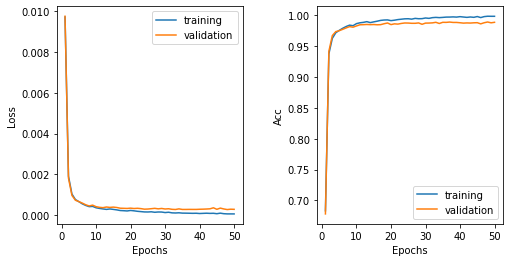

エポック1 ,val_acc0.6066 ,train_acc0.6113
epochtime:0.11677089929580689分
エポック2 ,val_acc0.7566 ,train_acc0.7641666666666667
epochtime:0.11505961020787557分
エポック3 ,val_acc0.7856 ,train_acc0.7959333333333334
epochtime:0.11539812882741292分
エポック4 ,val_acc0.8139 ,train_acc0.8248666666666666
epochtime:0.11517513195673625分
エポック5 ,val_acc0.8191 ,train_acc0.8329166666666666
epochtime:0.11505273977915446分
エポック6 ,val_acc0.8301 ,train_acc0.8509166666666667
epochtime:0.11540416479110718分
エポック7 ,val_acc0.8415 ,train_acc0.8572833333333333
epochtime:0.11609344879786174分
エポック8 ,val_acc0.8404 ,train_acc0.8546333333333334
epochtime:0.11656182607014974分
エポック9 ,val_acc0.8525 ,train_acc0.8699
epochtime:0.11569068829218547分
エポック10 ,val_acc0.8559 ,train_acc0.8770166666666667
epochtime:0.11381279230117798分
エポック11 ,val_acc0.8494 ,train_acc0.8704666666666667
epochtime:0.11497987906138102分
エポック12 ,val_acc0.858 ,train_acc0.8796666666666667
epochtime:0.11499973535537719分
エポック13 ,val_acc0.8618 ,train_acc0.8833166666666666

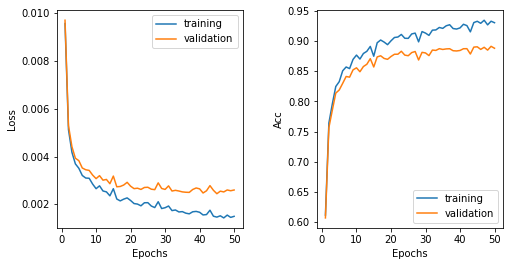

In [17]:
DL.train_model(m_l_t,m_l_v,modellist[0],criterion,optimizerlist[0],50,device)
DL.train_model(fm_l_t,fm_l_v,modellist[1],criterion,optimizerlist[1],50,device)
md_path='./drive/MyDrive/model_param/mnist/mnist_28_e50_128_0.05.pth'
torch.save(modellist[0].state_dict(), md_path)
md_path='./drive/MyDrive/model_param/fm/fm_28_e50_128_0.05.pth'
torch.save(modellist[1].state_dict(), md_path)

batch128 lr0.05

エポック1 ,val_acc0.9701 ,train_acc0.9673833333333334
epochtime:0.11784557898839315分
エポック2 ,val_acc0.9796 ,train_acc0.9774166666666667
epochtime:0.1151202122370402分
エポック3 ,val_acc0.9838 ,train_acc0.9846333333333334
epochtime:0.11393937269846598分
エポック4 ,val_acc0.984 ,train_acc0.9849666666666667
epochtime:0.1131549596786499分
エポック5 ,val_acc0.9879 ,train_acc0.9908
epochtime:0.11477575302124024分
エポック6 ,val_acc0.9858 ,train_acc0.9889833333333333
epochtime:0.11408663193384806分
エポック7 ,val_acc0.9853 ,train_acc0.9905166666666667
epochtime:0.11423848867416382分
エポック8 ,val_acc0.9877 ,train_acc0.9922833333333333
epochtime:0.12003153165181478分
エポック9 ,val_acc0.9907 ,train_acc0.9936666666666667
epochtime:0.11857314904530843分
エポック10 ,val_acc0.9904 ,train_acc0.99465
epochtime:0.11819432179133098分
エポック11 ,val_acc0.9899 ,train_acc0.9938833333333333
epochtime:0.11625314553578694分
エポック12 ,val_acc0.9893 ,train_acc0.9954666666666667
epochtime:0.11642698844273885分
エポック13 ,val_acc0.9905 ,train_acc0.9957
epochtime:0.

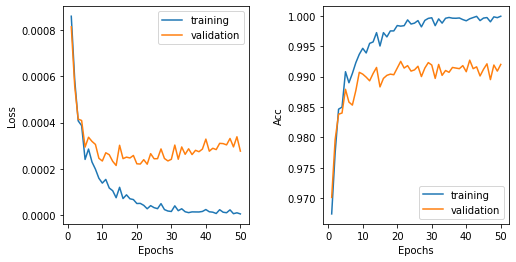

エポック1 ,val_acc0.7947 ,train_acc0.8020666666666667
epochtime:0.1186622182528178分
エポック2 ,val_acc0.8406 ,train_acc0.8504833333333334
epochtime:0.11865036090215048分
エポック3 ,val_acc0.8554 ,train_acc0.8656333333333334
epochtime:0.11853191057840982分
エポック4 ,val_acc0.8614 ,train_acc0.8763166666666666
epochtime:0.11868541240692139分
エポック5 ,val_acc0.846 ,train_acc0.8636166666666667
epochtime:0.1166773796081543分
エポック6 ,val_acc0.8787 ,train_acc0.8955666666666666
epochtime:0.11649965047836304分
エポック7 ,val_acc0.8787 ,train_acc0.89835
epochtime:0.1165749748547872分
エポック8 ,val_acc0.8779 ,train_acc0.9002833333333333
epochtime:0.11669613520304362分
エポック9 ,val_acc0.8775 ,train_acc0.9008166666666667
epochtime:0.11573631763458252分
エポック10 ,val_acc0.8784 ,train_acc0.9029833333333334
epochtime:0.1152546485265096分
エポック11 ,val_acc0.8885 ,train_acc0.9127166666666666
epochtime:0.1147948662439982分
エポック12 ,val_acc0.868 ,train_acc0.8923
epochtime:0.11642303864161173分
エポック13 ,val_acc0.8861 ,train_acc0.9158666666666667
epoc

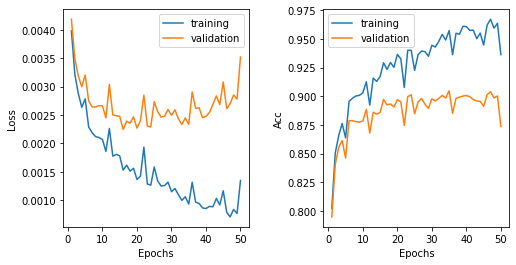

In [13]:
DL.train_model(m_l_t,m_l_v,modellist[0],criterion,optimizerlist[0],50,device)
DL.train_model(fm_l_t,fm_l_v,modellist[1],criterion,optimizerlist[1],50,device)
md_path='./drive/MyDrive/model_param/mnist_28_e50_128_0.05.pth'
torch.save(modellist[0].state_dict(), md_path)
md_path='./drive/MyDrive/model_param/fm_28_e50_128_0.05.pth'
torch.save(modellist[1].state_dict(), md_path)

batch64 lr0.01

エポック1 ,val_acc0.9173 ,train_acc0.9123833333333333
epochtime:0.1591023564338684分
エポック2 ,val_acc0.9676 ,train_acc0.9657166666666667
epochtime:0.15557895501454672分
エポック3 ,val_acc0.976 ,train_acc0.9765166666666667
epochtime:0.15378329356511433分
エポック4 ,val_acc0.9811 ,train_acc0.98235
epochtime:0.15422393480936686分
エポック5 ,val_acc0.9828 ,train_acc0.9845833333333334
epochtime:0.15230865875879923分
エポック6 ,val_acc0.9821 ,train_acc0.9855333333333334
epochtime:0.1564125418663025分
エポック7 ,val_acc0.9854 ,train_acc0.9871666666666666
epochtime:0.15623596906661988分
エポック8 ,val_acc0.9846 ,train_acc0.9871333333333333
epochtime:0.15434145132700602分
エポック9 ,val_acc0.9869 ,train_acc0.9896
epochtime:0.15457945267359416分
エポック10 ,val_acc0.9877 ,train_acc0.99155
epochtime:0.15362539291381835分
エポック11 ,val_acc0.9877 ,train_acc0.9920166666666667
epochtime:0.15577754179636638分
エポック12 ,val_acc0.9895 ,train_acc0.9921666666666666
epochtime:0.15678109327952067分
エポック13 ,val_acc0.9895 ,train_acc0.9923
epochtime:0.15647994677

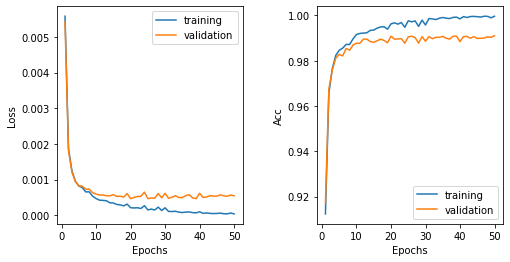

エポック1 ,val_acc0.7426 ,train_acc0.7459833333333333
epochtime:0.15778772433598837分
エポック2 ,val_acc0.8077 ,train_acc0.8114333333333333
epochtime:0.1572439710299174分
エポック3 ,val_acc0.8307 ,train_acc0.8416166666666667
epochtime:0.15739914178848266分
エポック4 ,val_acc0.8387 ,train_acc0.8485166666666667
epochtime:0.15713906288146973分
エポック5 ,val_acc0.858 ,train_acc0.8734833333333333
epochtime:0.15696741342544557分
エポック6 ,val_acc0.8507 ,train_acc0.8686333333333334
epochtime:0.1578305681546529分
エポック7 ,val_acc0.8582 ,train_acc0.8735666666666667
epochtime:0.15880768696467082分
エポック8 ,val_acc0.8656 ,train_acc0.8854833333333333
epochtime:0.15762286980946857分
エポック9 ,val_acc0.8692 ,train_acc0.8861
epochtime:0.15898882150650023分
エポック10 ,val_acc0.8665 ,train_acc0.8878166666666667
epochtime:0.1567511796951294分
エポック11 ,val_acc0.868 ,train_acc0.88845
epochtime:0.1589604616165161分
エポック12 ,val_acc0.858 ,train_acc0.88085
epochtime:0.1590619444847107分
エポック13 ,val_acc0.8781 ,train_acc0.9038166666666667
epochtime:0.1577

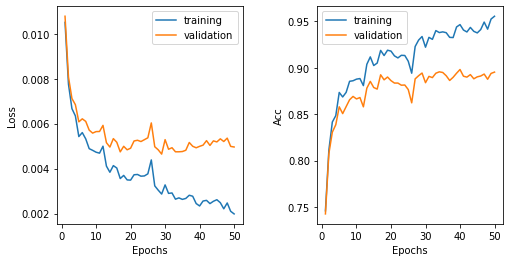

In [10]:
DL.train_model(m_l_t,m_l_v,modellist[0],criterion,optimizerlist[0],50,device)
DL.train_model(fm_l_t,fm_l_v,modellist[1],criterion,optimizerlist[1],50,device)
md_path='./drive/MyDrive/model_param/mnist_28_e50.pth'
torch.save(modellist[0].state_dict(), md_path)
md_path='./drive/MyDrive/model_param/fm_28_e50.pth'
torch.save(modellist[1].state_dict(), md_path)